# Twitter Climate Change Sentiment Analysis

- Author: Roelle Kim
- Date: 2022-04-05


# Used Dataset

"Twitter Climate Change Sentiment" at https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset.


# Objective

The goal for the model is to distinguish tweets about climate change into one of the three labels:

- 2: news - factual news about the climate change
- 1: pro - support the belief that climate change is caused by the man-kinds.
- 0: neutral
- -1: anti - refuse the belief that climate change is caused by the man-kinds


# EDA


## Load Packages and Data

Before analyzing data, we need to import required packages and the dataset.


In [172]:
# pip install pydataset

In [173]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn import metrics
from pydataset import data
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import pickle
import json

import kagglehub
from kagglehub import KaggleDatasetAdapter

In [174]:
file_path = "twitter_sentiment_data.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "edqian/twitter-climate-change-sentiment-dataset",
    file_path,
)

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_30740/2489314432.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


In [175]:
# drop rows where sentiment is 2 (news)
df = df[df["sentiment"] != 2]
df.reset_index(drop=True, inplace=True)

In [176]:
# set up label dataframe for future refrences

label = [
    -1,
    0,
    1,
    #  2
]
labelN = [
    "Anti",
    "Neutral",
    "Pro",
    #   "News"
]
labelDesc = [
    "the tweet does not believe in man-made climate change",
    "the tweet neither supports nor refutes the belief of man-made climate change",
    "the tweet supports the belief of man-made climate change",
    # , "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(
    list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"]
)

## Data Dictionary


In [177]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,0,Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X,793125429418815489


The data has a very simple structure with only 2 features. Each row is associated with a unique tweetid, and it shows a tweet pertaining to man-made climate change. The message column shows the content of the tweet and the sentiment column shows the sentiment label that was determined by 3 reviewers.


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34667 entries, 0 to 34666
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  34667 non-null  int64 
 1   message    34667 non-null  object
 2   tweetid    34667 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 812.6+ KB


There are total of 43949 entries with no null counts.


## Distribution of Sentiments


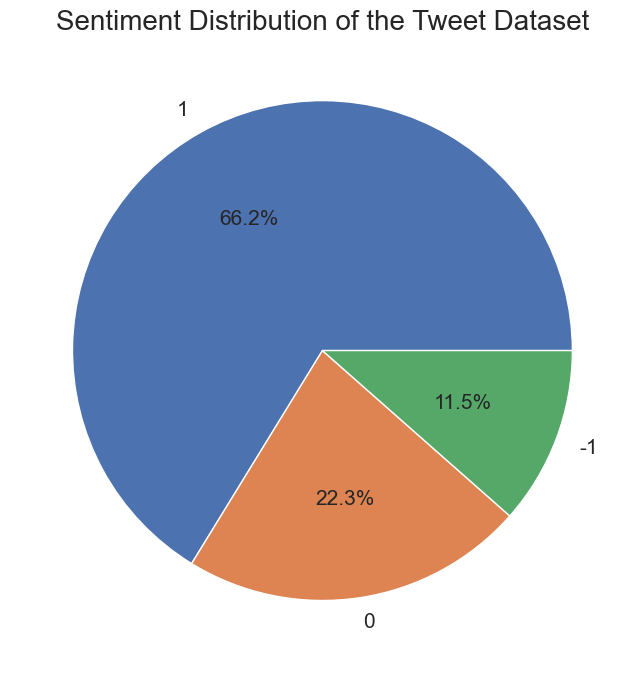

In [179]:
plt.figure(figsize=(7, 7))
plt.pie(
    df.sentiment.value_counts().values,
    labels=df.sentiment.value_counts().index,
    autopct="%2.1f%%",
    textprops={"fontsize": 15},
)
plt.title("Sentiment Distribution of the Tweet Dataset", fontsize=20)
plt.tight_layout()
plt.show()

The pie chart shows the distribution of the data. Majority of tweets are labelled as "1" meaning the positive attitude toward the belief that the climate change is caused by the man-kinds, followed by "2"(news), "0"(neutral), and "-1"(anti).


In [180]:
df.sentiment.value_counts()

sentiment
 1    22962
 0     7715
-1     3990
Name: count, dtype: int64

These are the exact numbers of each sentiment label.


# Data Preparation for Sentiment Analysis

Tweet texts will be transformed and vectorized to be fed into models.


In [181]:
# separate the messages column for transformation.
dfTweets = df["message"]

In [182]:
dfTweets

0        @tiniebeany climate change is an interesting hustle as it was global warming but the p...
1        RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...
2        Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...
3        RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...
4                            Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X
                                                   ...                                            
34662         #AikBaatSuniThi \nGlobal warming has negative effect on the melting down of glaciers
34663    Dear @realDonaldTrump,\nYeah right. Human Mediated Climate Change is a Chinese urban l...
34664          What will your respective parties do to prevent climate change globally? #ZPNDebate
34665    RT @taehbeingextra: i still can$q$t believe this gif of taehyung saved the human race,...
34666    @

## Tokenization

All the tweets are first split into arrays of words.


In [183]:
def createTokenizedArray(sentences):
    """
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    """
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r"\w+")
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [184]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4              [unamshow, awache, kujinga, na, iko, global, warming, https, t, co, mhiflu7m1x]
dtype: object

Each array contains words of individual tweet.


## Stop Word Removal

Stop words are the words that do not add any significant values to the query search, such as "the", "a", and "an". They are safe to be removed from the tokenized list.


In [185]:
# To get stop words.
nltk.download("stopwords")


def removeStopWords(tokenList):
    """
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    """
    stopWords = set(stopwords.words("english"))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:
                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if len(word) > 1 and word.isdigit() == False:
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to /Users/nafis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [186]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


You can see the second set of the array now no longer contains some insignificant words such as "is", "an", "as" and "it".


## Stemming

English words are often time variations of a root word. Stemming rebuilds sentences by removing suffixes from words. It potentially improves the sentiment algorithm by accepting different words as one word as long as they were originated from the same stem.


In [187]:
def stemWords(sentenceArrays):
    """
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    """
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimeter = " "
        sentence = delimeter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [188]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom


You can see the sentence after stemming has lost some suffixes. "Change" became "chang", "interesting" became "interest" and "warming" became "warm". The array of words has also been converted back to one full sentence.


## Vectorization

Now the stemmed sentences will be vectorized. It essentially transforms all the existing words into numbers so they can be fed to various big data algorithms.


In [189]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    """
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    """
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [190]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

Let's look into 2 different sample sentences to understand better what vectorization does


In [191]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


Notice these 2 sentences have a couple of words in common - "climat", "chang"


In [192]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12 stored elements and shape (1, 54331)>
  Coords	Values
  (0, 8170)	1
  (0, 10062)	1
  (0, 10801)	1
  (0, 19704)	1
  (0, 22345)	1
  (0, 23653)	1
  (0, 36745)	1
  (0, 44393)	1
  (0, 44948)	1
  (0, 46697)	1
  (0, 50288)	1
  (0, 52533)	1
#2 after vectorization:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15 stored elements and shape (1, 54331)>
  Coords	Values
  (0, 7109)	1
  (0, 10062)	1
  (0, 10801)	1
  (0, 11188)	1
  (0, 22189)	1
  (0, 22197)	1
  (0, 28183)	1
  (0, 28688)	1
  (0, 32626)	1
  (0, 40094)	1
  (0, 40752)	1
  (0, 45292)	1
  (0, 47234)	1
  (0, 50354)	1
  (0, 51349)	1


The prints above show the results of 2 sample sentences after being ve. Each vector signifies a unique word in all tweets. For example, we already know they have 2 words in common; therefore, we can see 2 sets of vectors appearing in both sentences - **(0, 12943)** and **(0, 13774)** - which are representations of "climat" and "chang" respectively.


In [193]:
vectorizedTweets.shape

(34667, 54331)

Based on the column size of our vectorized data, we can see there were 67195 unique words (no stop words, stemmed) in 43943 tweets in the dataset.


## Bi-Grams

Using N-Grams, we can group N numbers of words together and analyze their frequencies for specific sentiment rating.


In [194]:
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf["sentiment"] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf["transformedTweets"]]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = " "
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram": delimiter.join(counterList[i][0]),
            "Occurrences": counterList[i][1],
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [195]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the stemmed data.
df["transformedTweets"] = stemmedLi
dfSub = df[["sentiment", "transformedTweets"]]

We'll look in to top 20 bi-grams for each sentiment label.


### Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets (-1)



***N-Gram (Sentiment: -1)
                N-Gram  Occurrences
0         climat chang         2211
1              http co         1873
2          global warm         1855
3             man made          174
4           chang http          150
5     rt stevesgoddard          118
6            warm http          114
7              al gore          103
8              http rt           91
9   rt realdonaldtrump           87
10         made climat           86
11         made global           73
12             warm rt           72
13            chang rt           66
14          chang real           65
15         warm climat           61
16           warm hoax           60
17       believ climat           54
18          chang hoax           53
19         caus global           48


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_30740/2879157074.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

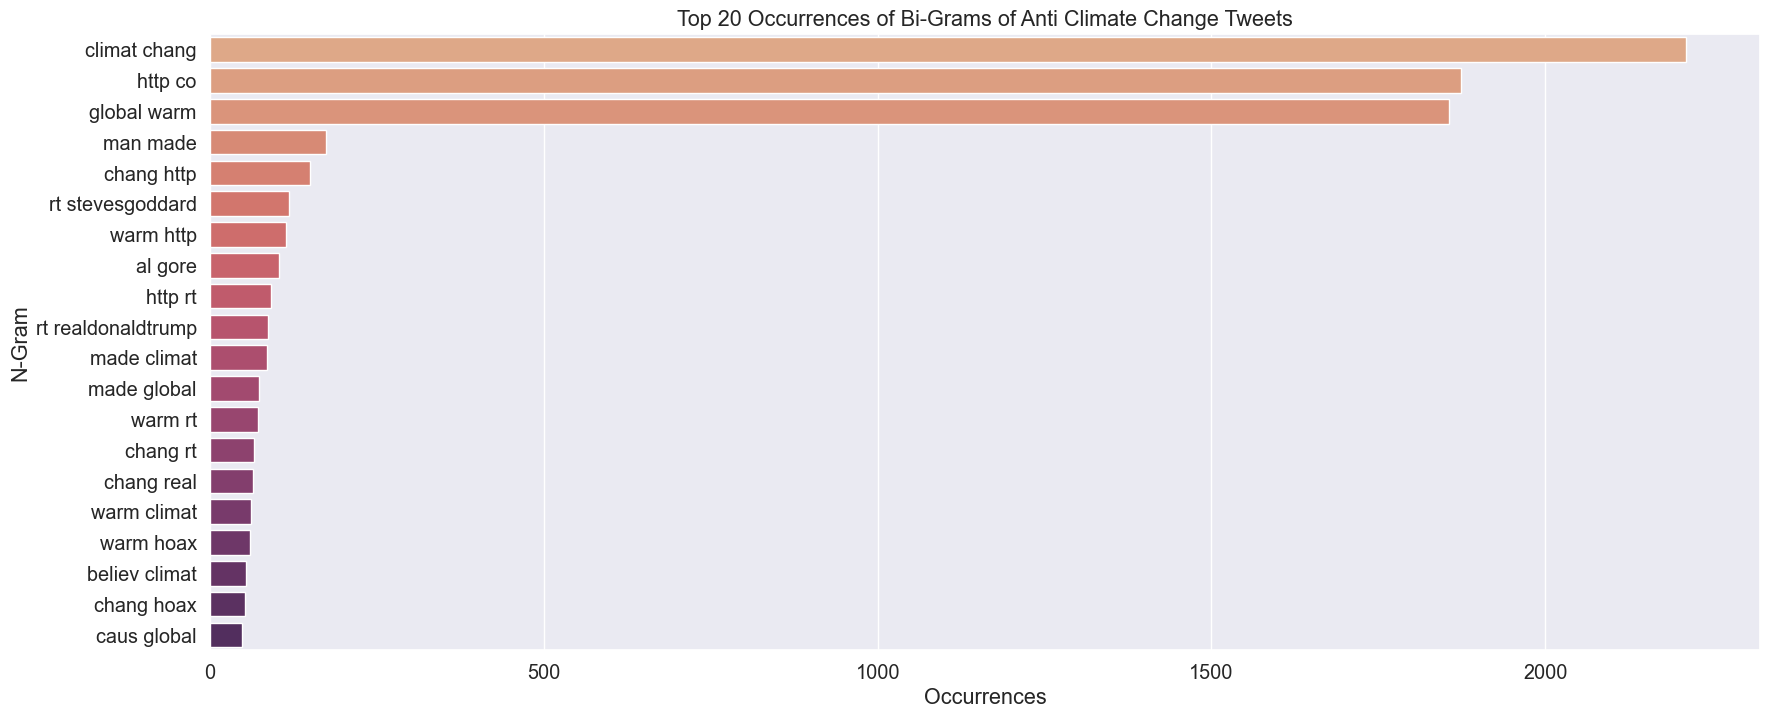

In [196]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

"climat change", "http co" and "global warm" have appeared the most time in the tweets that are refuting climate change is caused by humans. "http co" seems like a link to another website.


### Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets (0)



***N-Gram (Sentiment: 0)
           N-Gram  Occurrences
0    climat chang         4491
1         http co         3271
2     global warm         3109
3      chang http          447
4       warm http          289
5         warm rt          236
6        chang rt          218
7     caus global          137
8       warm real          121
9         http rt          109
10  believ climat          107
11    talk climat           99
12          ðÿ ðÿ           88
13   think global           82
14   club penguin           82
15     chang real           81
16  believ global           75
17    caus climat           70
18   penguin shut           68
19     chang hoax           63


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_30740/2155537556.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

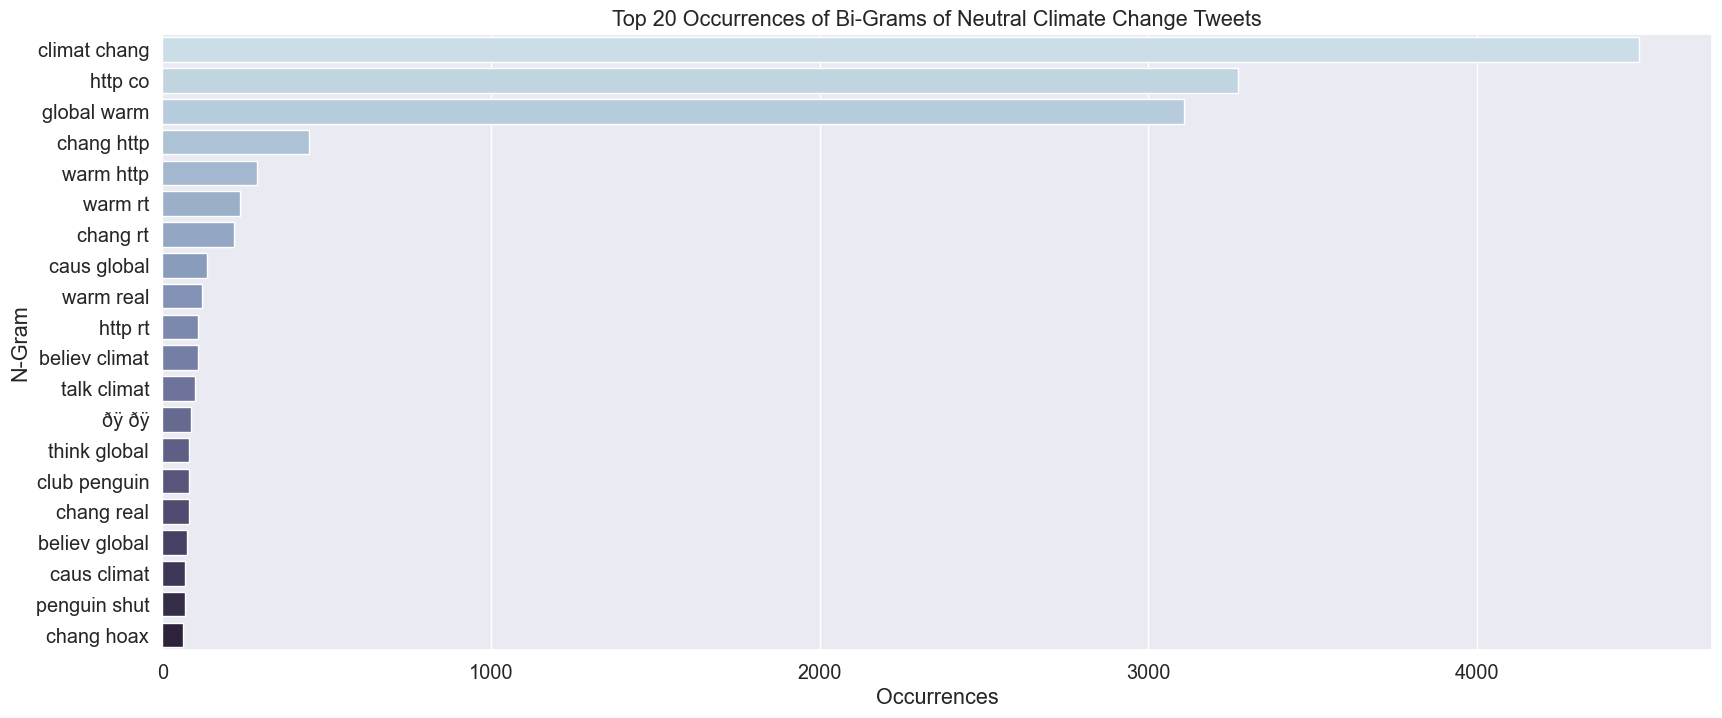

In [197]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25"
)

Neutral tweets also have very similar patterns to the anti tweets. "climat chang", "http co" and "global warm" are the top 3 followed by "chang http", "warm http", "warm rt" and "chang rt". "rt" is short for "re-tweet".
The only difference may be notable here is that "man made" was not mentioned as the top 20 occurrences in the neutral tweets.


### Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets (1)



***N-Gram (Sentiment: 1)
                   N-Gram  Occurrences
0            climat chang        19124
1                 http co        12378
2             global warm         3851
3              chang http         2799
4           believ climat         1427
5            fight climat          836
6                 http rt          788
7            chang denier          711
8              chang real          679
9                  go die          540
10               think go          514
11         husband believ          512
12            die husband          510
13     rt stephenschlegel          507
14  stephenschlegel think          507
15             co sjofonã          506
16              warm http          494
17               chang rt          477
18            deni climat          448
19             sjofonã rt          435


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_30740/3802794499.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

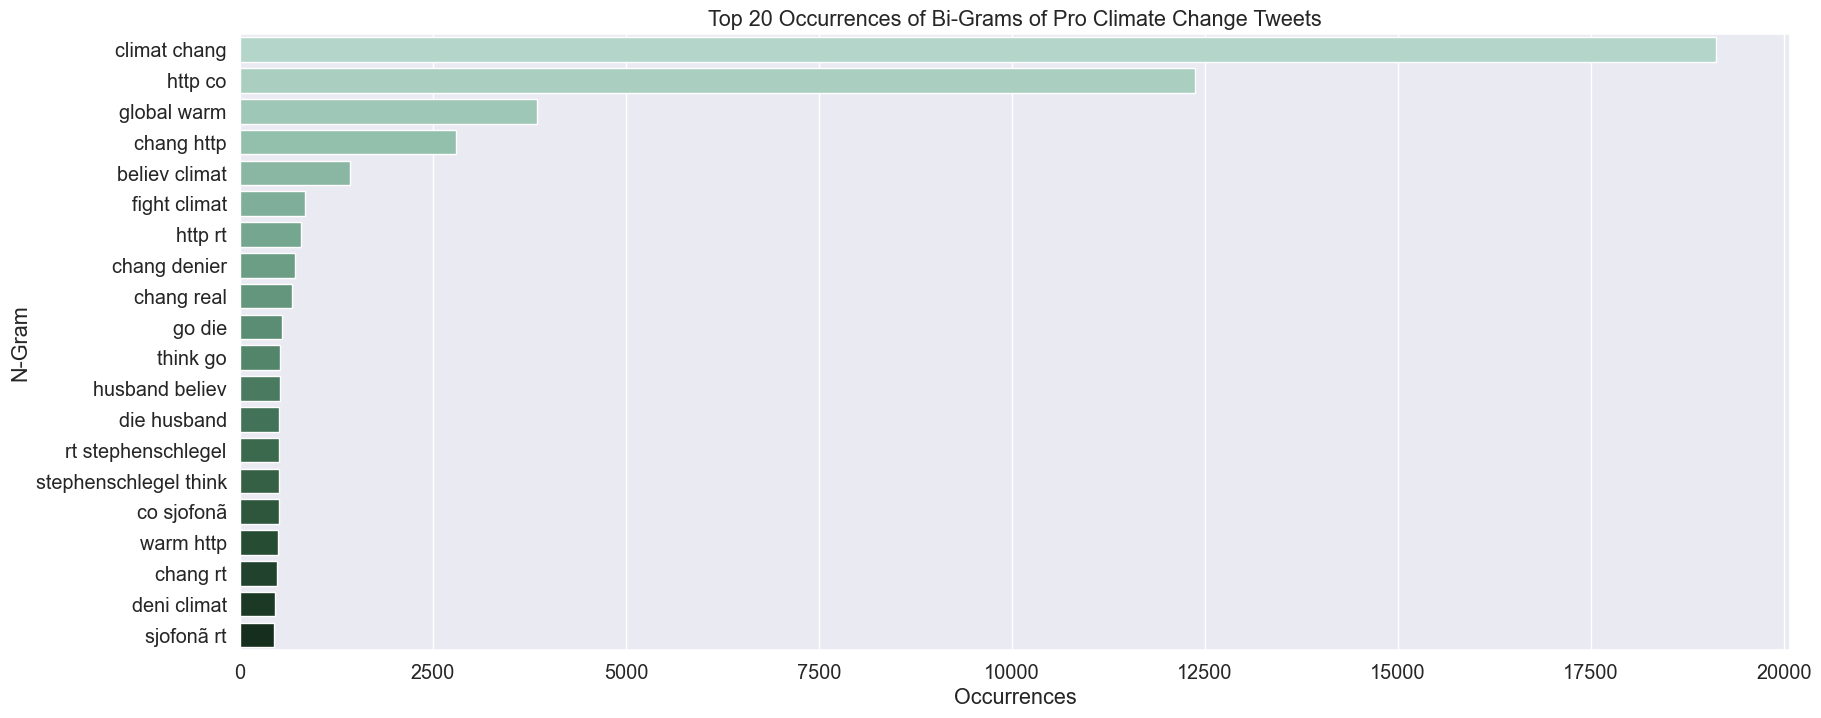

In [198]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8"
)

Again, the top 3 bi-grams are "climat chang", "http co" and "global warm" for pro climate change tweets. A considerable size of tweets are containing "believ climat" and "fight climat". Perhaps people were explicitly expressing that they are "believing in climate change" or "fighting for the climate change".


## Tri-Grams

Let's try tri-grams and see if it finds more meaningful combinations of words than bi-grams.


In [199]:
SIZE = 3

## Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets (-1)



***N-Gram (Sentiment: -1)
                 N-Gram  Occurrences
0     climat chang http          146
1         chang http co          138
2      global warm http          112
3          warm http co          105
4     made climat chang           82
5       man made climat           78
6        global warm rt           71
7      made global warm           71
8       man made global           67
9     climat chang real           65
10      climat chang rt           61
11     global warm hoax           60
12   global warm climat           59
13    climat chang hoax           52
14  believ climat chang           52
15    warm climat chang           50
16     global warm data           45
17    caus climat chang           44
18     caus global warm           44
19    global warm creat           43


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_30740/2990623308.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

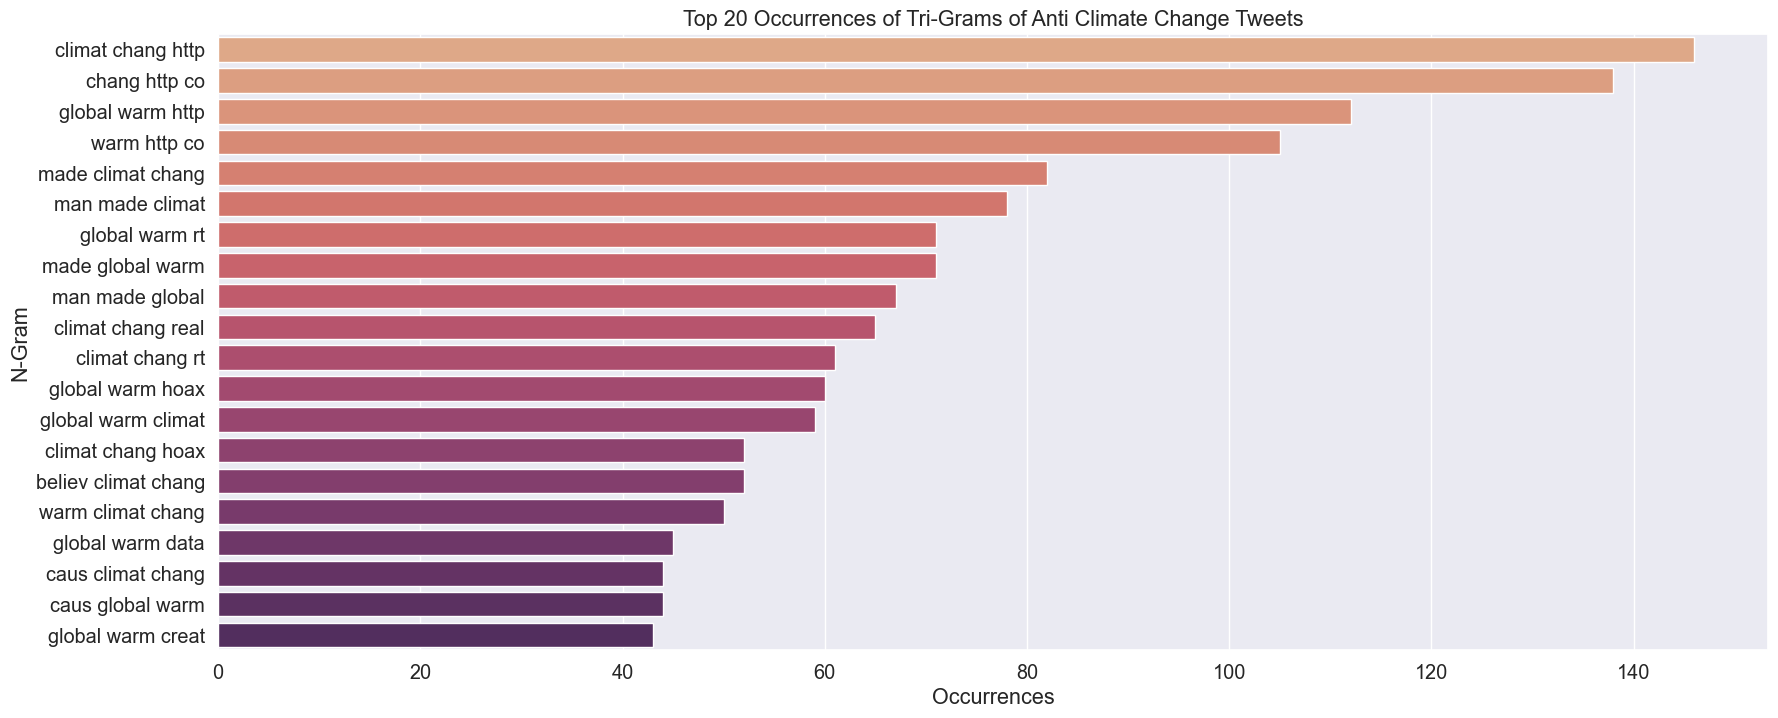

In [200]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

### Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets (0)



***N-Gram (Sentiment: 0)
                 N-Gram  Occurrences
0     climat chang http          444
1         chang http co          424
2      global warm http          289
3          warm http co          280
4        global warm rt          235
5       climat chang rt          214
6      caus global warm          137
7      global warm real          121
8   believ climat chang          106
9     talk climat chang           96
10    think global warm           81
11    climat chang real           81
12   believ global warm           74
13    caus climat chang           69
14    club penguin shut           68
15    climat chang hoax           63
16   think climat chang           58
17     stop global warm           57
18   fight climat chang           56
19     say climat chang           52


/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_30740/2904435185.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

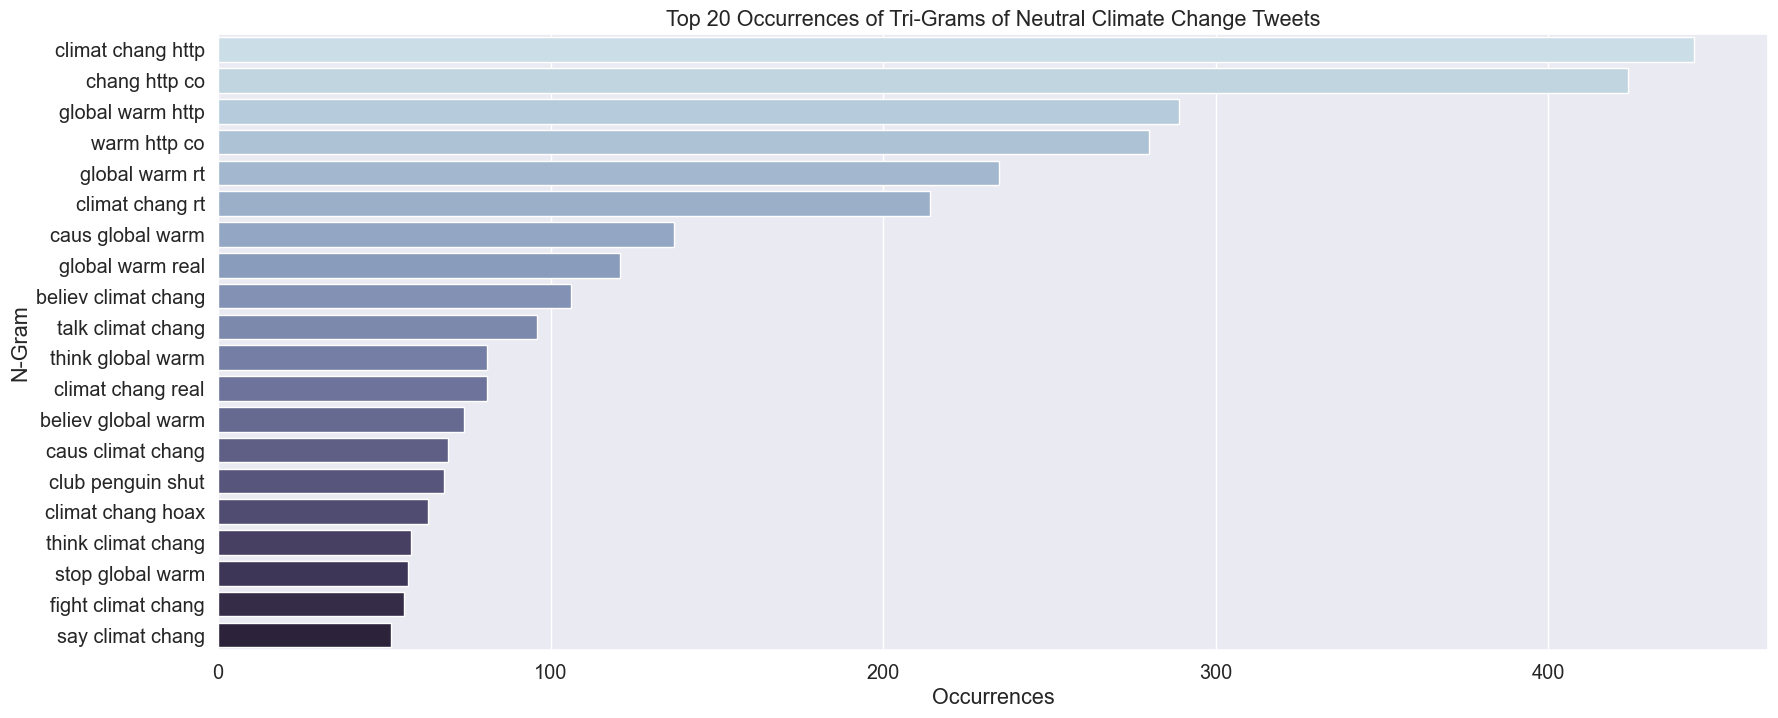

In [201]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(
    x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25"
)

### Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets (1)



***N-Gram (Sentiment: 1)
                      N-Gram  Occurrences
0          climat chang http         2787
1              chang http co         2635
2        believ climat chang         1422
3         fight climat chang          822
4        climat chang denier          711
5          climat chang real          679
6      husband believ climat          512
7               think go die          510
8             go die husband          510
9         die husband believ          510
10  rt stephenschlegel think          507
11  stephenschlegel think go          507
12           http co sjofonã          506
13          global warm http          480
14              warm http co          470
15           climat chang rt          465
16             co sjofonã rt          435
17         deni climat chang          428
18        tackl climat chang          385
19       combat climat chang          366
                      N-Gram  Occurrences
0          climat chang http         2787
1       

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_30740/4132814696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

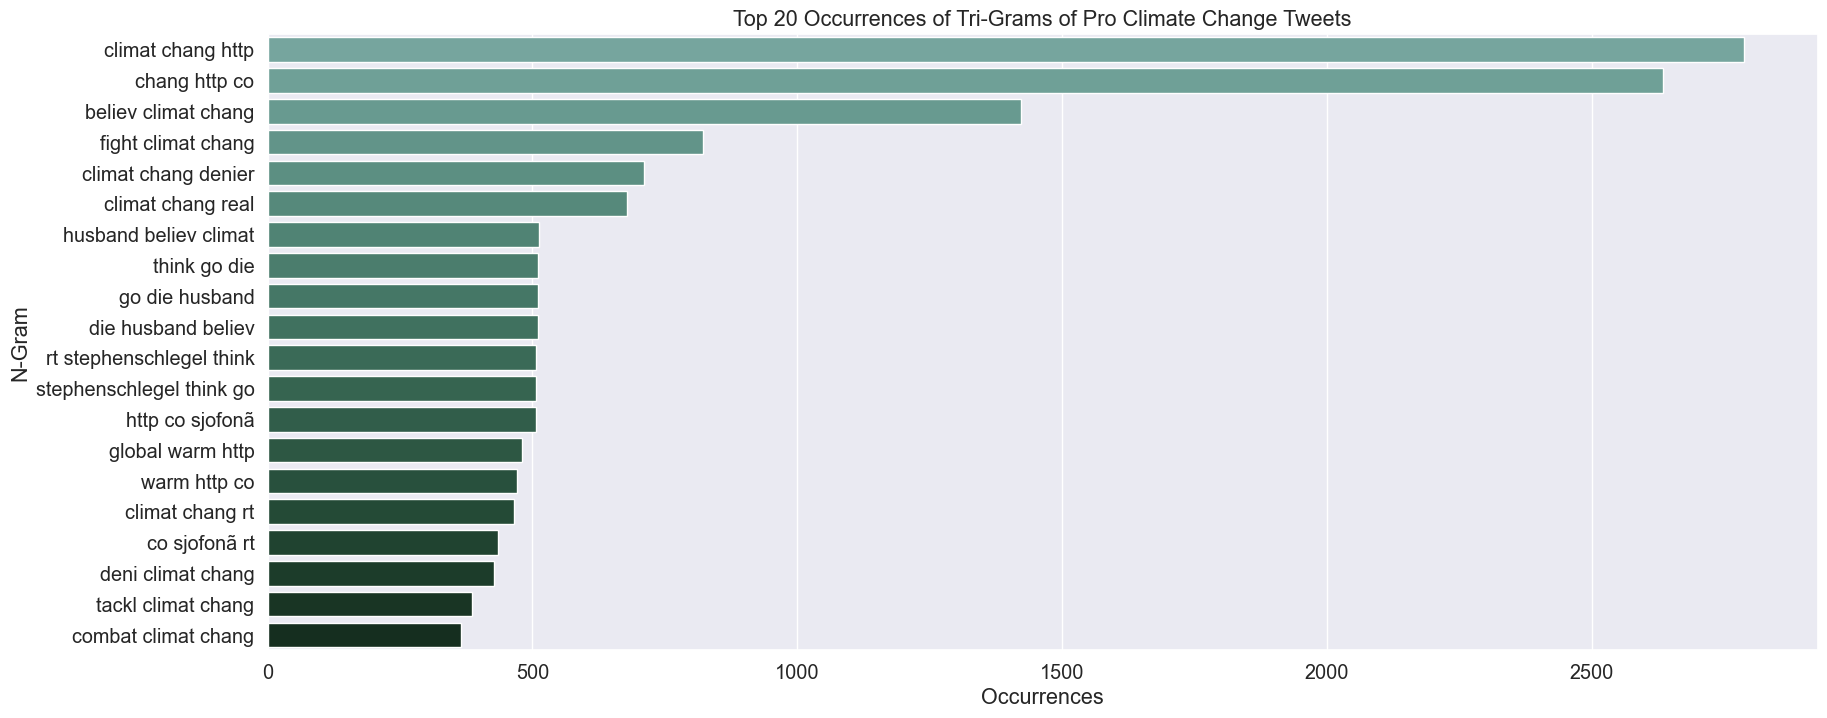

In [202]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style("darkgrid")
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")

Overall, it seems like tri-grams grab more accurate actions or emotions associated with climate change or global warming.


# Model Development

Various models will be built to predict the sentiment of tweets pertaining to climate change.


In [203]:
def evaluateModel(model, X_test, y_test, title):
    """
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    """
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average="weighted")
    precision = metrics.precision_score(y_test, predictions, average="weighted")
    f1 = metrics.f1_score(y_test, predictions, average="weighted")

    clsScoreDict = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [204]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__
    
    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.8, random_state=42)

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [205]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    """
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    """
    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = [
        "Actual -1",
        "Actual 0",
        "Actual 1",
        #  'Actual 2',
    ]
    Cols = [
        "Pred -1",
        "Pred 0",
        "Pred 1",
        # 'Pred 2'
    ]
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))

    ax = sns.heatmap(df, cmap="Blues", annot=True, fmt="g")
    bottom, top = ax.get_ylim()
    ax.set(title="Climate Change Sentiment")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right")

In [206]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [207]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [208]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

In [209]:
# unigram & bi-gram vectorization
NGRAM_RANGE_START = 1
NGRAM_RANGE_END = 2

vectorizedTweets12, vectorDictionary12 = vectorizeList(
    stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END
)

## 1. Logistic Regression


In [210]:
model = LogisticRegression(random_state=42)


*** LogisticRegression ***
Accuracy:  0.7724257282953562
Precision: 0.7605379641273784
Recall:    0.7724257282953562
F1:        0.761908757303982



[[ 423  168  233]
 [  85  773  680]
 [  89  323 4160]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


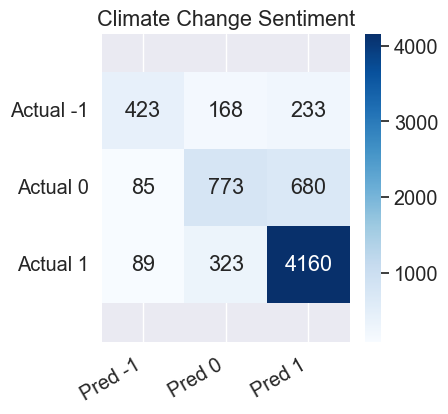

In [211]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram Logistic Regression



*** LogisticRegression ***
Accuracy:  0.7476204211133545
Precision: 0.7393141008182471
Recall:    0.7476204211133545
F1:        0.7209455512034207



[[ 270  178  376]
 [  34  617  887]
 [  18  257 4297]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


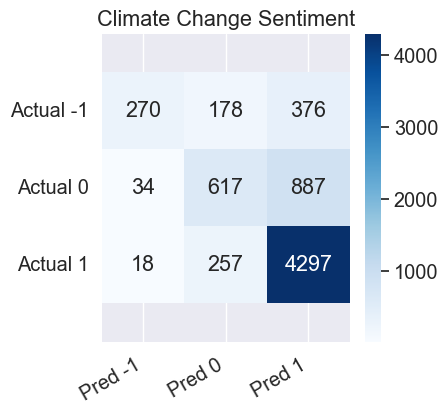

In [212]:
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(
    vectorizedTweets2, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Logistic Regression



*** LogisticRegression ***
Accuracy:  0.7117104124603404
Precision: 0.7024155258229575
Recall:    0.7117104124603404
F1:        0.662525817962311



[[ 182  104  538]
 [  19  395 1124]
 [  17  197 4358]]


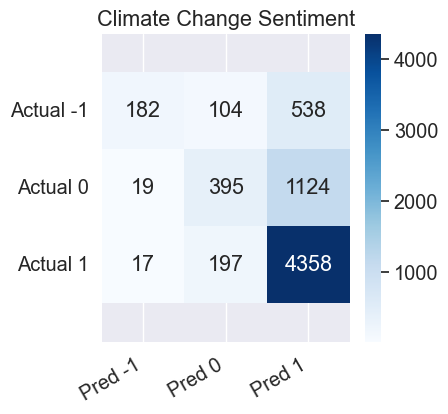

In [213]:
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(
    vectorizedTweets3, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Unigram & Bigram Combined Logistic Regression



*** LogisticRegression ***
Accuracy:  0.787424286126334
Precision: 0.7775276231582893
Recall:    0.787424286126334
F1:        0.7745654357940304



[[ 417  158  249]
 [  68  779  691]
 [  49  259 4264]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


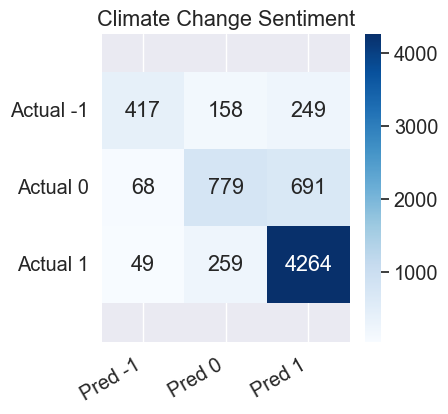

In [214]:
X_test, y_test, y_predicted, lrScoreDict12 = modelAndPredict(
    vectorizedTweets12, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Logistic Regression

Note that I was not able to vectorize data ranging from 1 to 3-gram due to memory issue on my device.



*** LogisticRegression ***
Accuracy:  0.7419959619267378
Precision: 0.7330748199150176
Recall:    0.7419959619267378
F1:        0.7141155345049306



[[ 243  185  396]
 [  33  622  883]
 [  20  272 4280]]


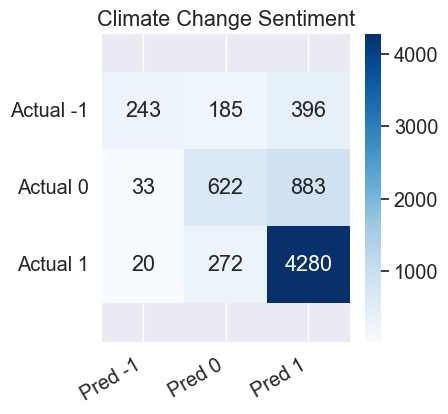

In [215]:
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(
    vectorizedTweets23, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### N-gram Comparisons

We have built different vectorized sentences using different ranges of N-grams (1, 2, 3, 1-2 combined, and 2 to 3). Each of them was fed to a logistic regression model and evaluated based on classification scores such as accuracy, precision, recall and F1. In this section, we will compare all the scores and see what N-gram has worked the best.


In [216]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["Unigram"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf12 = pd.DataFrame(lrScoreDict12, index=["Unigram & Bi-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat(
    [lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf12, lsScoreDf23]
)
lsScoreComparisonDf

,accuracy,recall,precision,f1
Unigram,0.772426,0.772426,0.760538,0.761909
Bi-gram,0.747620,0.747620,0.739314,0.720946
Tri-gram,0.711710,0.711710,0.702416,0.662526
Unigram & Bi-gram,0.787424,0.787424,0.777528,0.774565
Bi-gram and Tri-gram,0.741996,0.741996,0.733075,0.714116


Logistic regression has worked the best when no N-gram was used to vectorize the sentences. Let's see if we can improve the model even further using different classification models.


## 2. Random Forest Classifier


In [217]:
model = RandomForestClassifier(random_state=42)


*** RandomForestClassifier ***
Accuracy:  0.7546870493221806
Precision: 0.7480749119825381
Recall:    0.7546870493221806
F1:        0.72869037785162



Accuracy:  0.7546870493221806
Precision: 0.7480749119825381
Recall:    0.7546870493221806
F1:        0.72869037785162



[[ 268  152  404]
 [  34  655  849]
 [  21  241 4310]]
[[ 268  152  404]
 [  34  655  849]
 [  21  241 4310]]


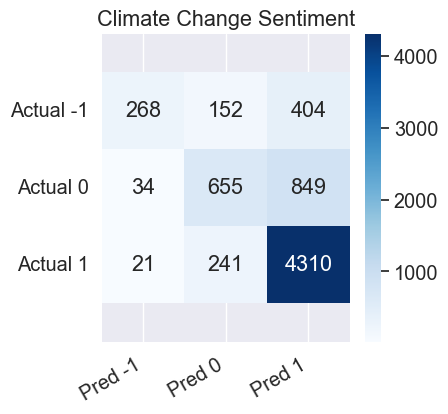

In [218]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 3. Multinomial Naive Bayes


In [219]:
model = MultinomialNB()


*** MultinomialNB ***
Accuracy:  0.7468993366022498
Precision: 0.7390695264153051
Recall:    0.7468993366022498
F1:        0.7098286002566259



[[ 247  103  474]
 [  59  520  959]
 [  18  142 4412]]


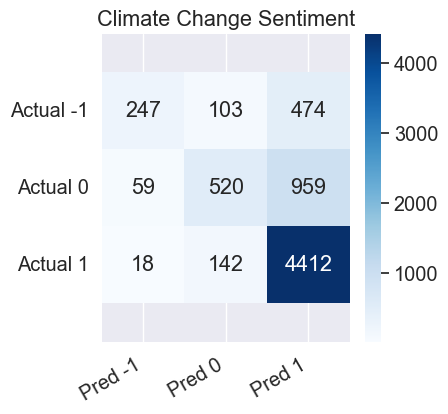

In [220]:
X_test, y_test, y_predicted, nbScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram Multinomial Naive Bayes



*** MultinomialNB ***
Accuracy:  0.7156042688203057
Precision: 0.7150518017078338
Recall:    0.7156042688203057
F1:        0.7148060074284892



[[ 397  204  223]
 [ 159  775  604]
 [ 141  641 3790]]


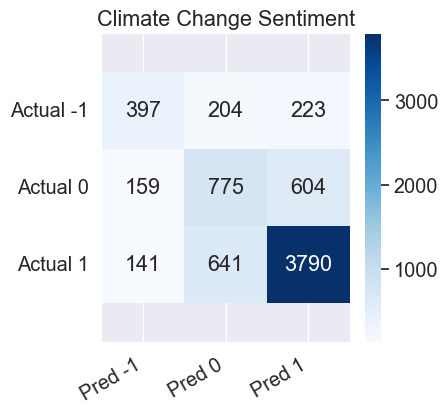

In [221]:
X_test, y_test, y_predicted, nbScoreDict2 = modelAndPredict(
    vectorizedTweets2, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Multinomial Naive Bayes



*** MultinomialNB ***
Accuracy:  0.5806172483415056
Precision: 0.6728414806451976
Recall:    0.5806172483415056
F1:        0.6069416670842213



[[ 431  253  140]
 [ 320  836  382]
 [ 588 1225 2759]]
[[ 431  253  140]
 [ 320  836  382]
 [ 588 1225 2759]]


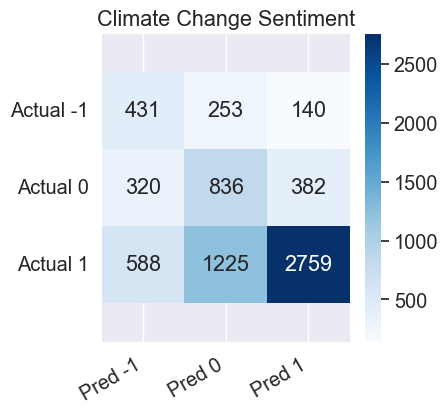

In [222]:
X_test, y_test, y_predicted, nbScoreDict3 = modelAndPredict(
    vectorizedTweets3, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Unigram & Bigram Combined Multinomial Naive Bayes



*** MultinomialNB ***
Accuracy:  0.7644937986732045
Precision: 0.754084384455716
Recall:    0.7644937986732045
F1:        0.7394065187066612



[[ 314  143  367]
 [  62  633  843]
 [  23  195 4354]]


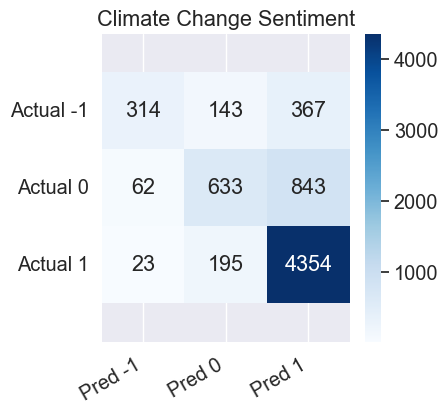

In [223]:
X_test, y_test, y_predicted, nbScoreDict12 = modelAndPredict(
    vectorizedTweets12, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Multinomial Naive Bayes



*** MultinomialNB ***
Accuracy:  0.6458032881453707
Precision: 0.7052447948877096
Recall:    0.6458032881453707
F1:        0.6650089300229378



[[ 492  199  133]
 [ 325  830  383]
 [ 461  955 3156]]
[[ 492  199  133]
 [ 325  830  383]
 [ 461  955 3156]]


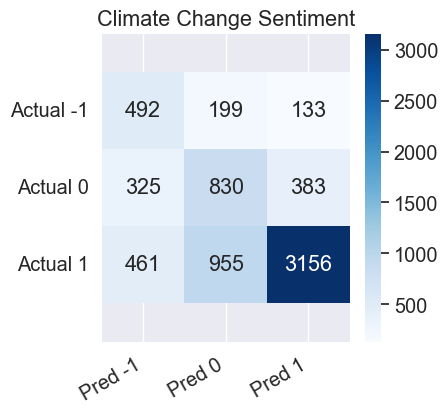

In [224]:
X_test, y_test, y_predicted, nbScoreDict23 = modelAndPredict(
    vectorizedTweets23, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

## 4. Ridge Classifier


In [225]:
model = RidgeClassifier(random_state=42)


*** RidgeClassifier ***
Accuracy:  0.7637727141620998
Precision: 0.7527453434034238
Recall:    0.7637727141620998
F1:        0.7530679561429452



[[ 413  177  234]
 [  73  750  715]
 [  72  367 4133]]


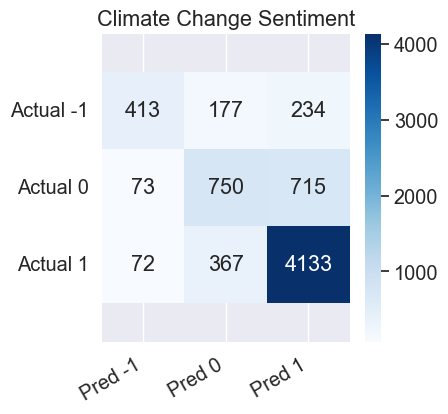

In [226]:
X_test, y_test, y_predicted, ridgeScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram Ridge Classifier



*** RidgeClassifier ***
Accuracy:  0.7474762042111336
Precision: 0.7383905596042022
Recall:    0.7474762042111336
F1:        0.7287118023683835



[[ 307  186  331]
 [  46  684  808]
 [  28  352 4192]]


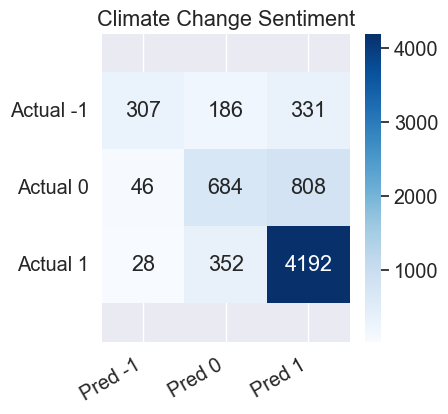

In [227]:
X_test, y_test, y_predicted, ridgeScoreDict2 = modelAndPredict(
    vectorizedTweets2, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Ridge Classifier



*** RidgeClassifier ***
Accuracy:  0.7131525814825498
Precision: 0.6955422450399592
Recall:    0.7131525814825498
F1:        0.6807021564435224



[[ 224  166  434]
 [  42  510  986]
 [  29  332 4211]]


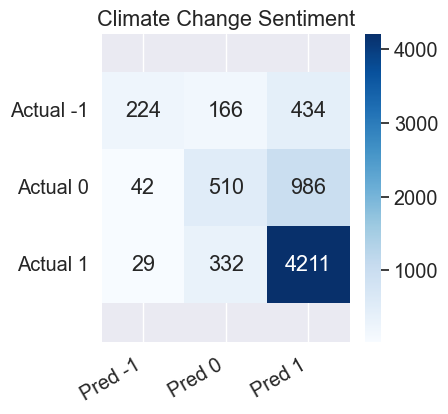

In [228]:
X_test, y_test, y_predicted, ridgeScoreDict3 = modelAndPredict(
    vectorizedTweets3, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Unigram & Bigram Combined Ridge Classifier



*** RidgeClassifier ***
Accuracy:  0.7810787424286126
Precision: 0.7710282237819449
Recall:    0.7810787424286126
F1:        0.770005012450133



[[ 424  160  240]
 [  73  787  678]
 [  57  310 4205]]


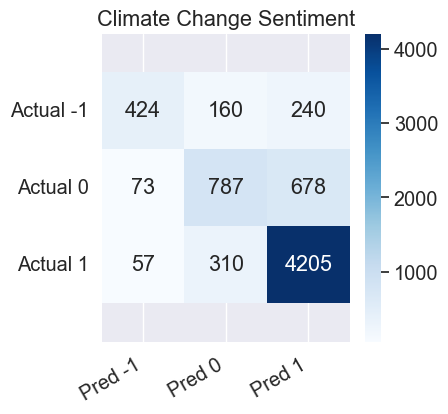

In [229]:
X_test, y_test, y_predicted, ridgeScoreDict12 = modelAndPredict(
    vectorizedTweets12, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Ridge Classifier



*** RidgeClassifier ***
Accuracy:  0.7432939140467263
Precision: 0.7364227027307053
Recall:    0.7432939140467263
F1:        0.7248342720606047



[[ 291  192  341]
 [  40  698  800]
 [  25  382 4165]]


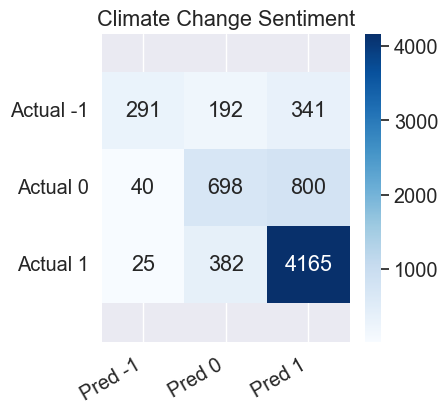

In [230]:
X_test, y_test, y_predicted, ridgeScoreDict23 = modelAndPredict(
    vectorizedTweets23, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

# Model Comparisons


In [231]:
# Logistic Regression scores for different N-grams  
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression (Unigram)"])
lrScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Logistic Regression (Bi-gram)"])
lrScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Logistic Regression (Tri-gram)"])
lrScoreDf12 = pd.DataFrame(lrScoreDict12, index=["Logistic Regression (Unigram & Bi-gram)"])
lrScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Logistic Regression (Bi-gram & Tri-gram)"])

# Random Forest scores for different N-grams
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest (Unigram)"])

# Multinomial Naive Bayes scores for different N-grams
nbScoreDf = pd.DataFrame(nbScoreDict, index=["Multinomial Naive Bayes (Unigram)"])
nbScoreDf2 = pd.DataFrame(nbScoreDict2, index=["Multinomial Naive Bayes (Bi-gram)"])
nbScoreDf3 = pd.DataFrame(nbScoreDict3, index=["Multinomial Naive Bayes (Tri-gram)"])
nbScoreDf12 = pd.DataFrame(nbScoreDict12, index=["Multinomial Naive Bayes (Unigram & Bi-gram)"])
nbScoreDf23 = pd.DataFrame(nbScoreDict23, index=["Multinomial Naive Bayes (Bi-gram & Tri-gram)"])

# Ridge Classifier scores for different N-grams
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classifier (Unigram)"])
ridgeScoreDf2 = pd.DataFrame(ridgeScoreDict2, index=["Ridge Classifier (Bi-gram)"])
ridgeScoreDf3 = pd.DataFrame(ridgeScoreDict3, index=["Ridge Classifier (Tri-gram)"])
ridgeScoreDf12 = pd.DataFrame(ridgeScoreDict12, index=["Ridge Classifier (Unigram & Bi-gram)"])
ridgeScoreDf23 = pd.DataFrame(ridgeScoreDict23, index=["Ridge Classifier (Bi-gram & Tri-gram)"])

# Combine all model results
clsCompDf = pd.concat([
    # Logistic Regression
    lrScoreDf, lrScoreDf2, lrScoreDf3, lrScoreDf12, lrScoreDf23,
    # Random Forest
    rfScoreDf,
    # Multinomial Naive Bayes
    nbScoreDf, nbScoreDf2, nbScoreDf3, nbScoreDf12, nbScoreDf23,
    # Ridge Classifier
    ridgeScoreDf, ridgeScoreDf2, ridgeScoreDf3, ridgeScoreDf12, ridgeScoreDf23
])

clsCompDf.sort_values(by=["accuracy", "f1"], ascending=False)

,accuracy,recall,precision,f1
Logistic Regression (Unigram & Bi-gram),0.787424,0.787424,0.777528,0.774565
Ridge Classifier (Unigram & Bi-gram),0.781079,0.781079,0.771028,0.770005
Logistic Regression (Unigram),0.772426,0.772426,0.760538,0.761909
Multinomial Naive Bayes (Unigram & Bi-gram),0.764494,0.764494,0.754084,0.739407
Ridge Classifier (Unigram),0.763773,0.763773,0.752745,0.753068
Random Forest (Unigram),0.754687,0.754687,0.748075,0.728690
Logistic Regression (Bi-gram),0.747620,0.747620,0.739314,0.720946
Ridge Classifier (Bi-gram),0.747476,0.747476,0.738391,0.728712
Multinomial Naive Bayes (Unigram),0.746899,0.746899,0.739070,0.709829
Ridge Classifier (Bi-gram & Tri-gram),0.743294,0.743294,0.736423,0.724834


We can compare the performance of our four selected models: **Logistic Regression**, **Random Forest Classifier**, **Multinomial Naive Bayes**, and **Ridge Classifier** based on their accuracy, precision, recall, and F1 scores.


# Binary File Export

To reuse the built model to predict other tweets, we will be saving the model as a binary file.


In [232]:
def modelAndPredict(X, target, model):
    """
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    """

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.75, random_state=42)

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)

    # save model to a pickle file
    # create directory for models
    if not path.exists("./model"):
        makedirs("./model")
    pickle.dump(
        clfModel, open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "wb")
    )

    # load model
    loadedModel = pickle.load(
        open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "rb")
    )

    clsScoreDict = evaluateModel(loadedModel, X_test, y_test, modelType)

    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [233]:
model = LogisticRegression(random_state=42)


*** LogisticRegression ***
Accuracy:  0.7730471904926733
Precision: 0.7618839581685203
Recall:    0.7730471904926733
F1:        0.7631871004687943



[[ 531  211  292]
 [ 104  952  829]
 [ 103  428 5217]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


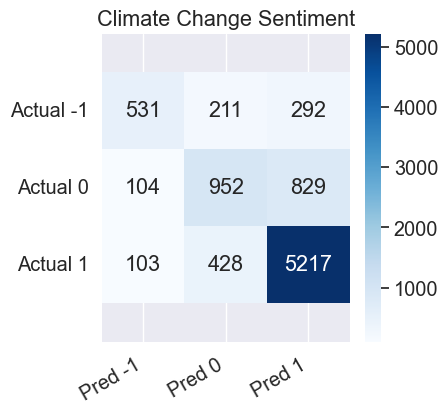

In [234]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(
    vectorizedTweets, df["sentiment"], model
)
showFormattedConfusionMatrix(y_test, y_predicted)

We also need a reference to vectors for each word found in the dataset. The word dictionary will be exported as a JSON file. Each unique word in the dataset is associated with its vector value.


In [235]:
# with open("wordDictionary.json", "w") as fp:
#     json.dump(vectorDictionary, fp)